# Libs

In [75]:
import pandas as pd
import sys, os 
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

from scr.utils import (
    normalizar_pais,
    agrupar_pais,
    comprobar_normalidad,
    correlacion_variables,
    comprobar_nomalidad_y_varianza,
    calcular_fuerza_asociacion_2_grupos,
    calcular_fuerza_asociacion_mas_2_grupos,
    cramers_v,
    calcular_independencia_categoricas,
    agrupar_tramo,
    cohens_d,
    r_mannwhitney,
    prueba_comparacion_2grupos_variable
)

# Funcs

In [120]:
#Gráficos
def plot_facturacion(df_convo_deuda, output_path=None):
    """
    Genera un gráfico stacked bar de la composición de la facturación
    pagada e impagada por tramos de % de pago inicial en la inscripción.

    Parámetros
    ----------
    df_convo_deuda : pd.DataFrame
        Debe contener las columnas:
        - '% INSCRIPCION'
        - 'FACTURACIÓN NETA'
        - 'Importe Impagado Actual'
        - 'Importe Cobrado'
    """

    # Copia de trabajo
    df_graff = df_convo_deuda[['% INSCRIPCION', 'FACTURACIÓN NETA',
                               'Importe Impagado Actual', 'Importe Cobrado']].copy()

    # Asegurar formato numérico y pasar a %
    df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'],
                                              errors='coerce') * 100

    # Crear tramos del 1%
    df_graff['TRAMO % INSCRIPCION'] = pd.cut(
        df_graff['% INSCRIPCION'],
        bins=range(0, 102, 1),
        right=False,
        labels=[f"{i}%" for i in range(0, 101)]
    )

    # Agrupar por tramo
    df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Eliminar tramos sin datos
    df_grouped = df_grouped[(df_grouped.T != 0).any()]

    # Calcular pendiente no vencido
    df_grouped['Pendiente no vencido'] = (
        df_grouped['FACTURACIÓN NETA']
        - df_grouped['Importe Impagado Actual']
        - df_grouped['Importe Cobrado']
    )

    # Calcular % impagado sobre deuda (opcional, útil para análisis extra)
    df_grouped['%II'] = (
        df_grouped['Importe Impagado Actual'] /
        (df_grouped['Importe Impagado Actual'] + df_grouped['Importe Cobrado'])
    ) * 100

    # Preparar datos para gráfico
    df_plot = df_grouped[['Pendiente no vencido',
                          'Importe Impagado Actual', 'Importe Cobrado']]

    # Graficar stacked bar
    ax = df_plot.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 6),
        color=['#1f77b4', "#AF1010", "#19c70d"]
    )

    plt.title('Distribución del impago según el % del pago inicial')
    plt.ylabel('Euros')
    plt.xlabel('% Inscripción')
    plt.legend(
        title='Concepto',
        labels=['Pendiente no vencido', 'Impagado vencido', 'Importe Cobrado']
    )
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico guardado en {output_path}")

    plt.show()

    return df_grouped  # devuelve el dataframe agregado por si quieres usarlo después


def plot_facturacion_prop(df_convo_deuda, output_path=None):
    """
    Genera un gráfico proporcional (100% stacked bar) de la composición de la facturación
    por tramos de % de inscripción y opcionalmente lo guarda como imagen.

    Parámetros
    ----------
    df_convo_deuda : pd.DataFrame
        Debe contener las columnas:
        - '% INSCRIPCION'
        - 'FACTURACIÓN NETA'
        - 'Importe Impagado Actual'
        - 'Importe Cobrado'

    output_path : str, opcional
        Ruta donde guardar la imagen (ej: 'grafico_prop.png').
        Si es None, no guarda nada.
    """

    # Copiar datos
    df_graff = df_convo_deuda[['% INSCRIPCION', 'FACTURACIÓN NETA',
                               'Importe Impagado Actual', 'Importe Cobrado']].copy()

    # Asegurar formato numérico (y convertir a %)
    df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'],
                                              errors='coerce') * 100

    # Crear tramos del 1%
    df_graff['TRAMO % INSCRIPCION'] = pd.cut(
        df_graff['% INSCRIPCION'],
        bins=range(0, 102, 1),
        right=False,
        labels=[f"{i}%" for i in range(0, 101)]
    )

    # Agrupar por tramo y sumar
    df_plot = df_graff.groupby('TRAMO % INSCRIPCION')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Eliminar tramos sin datos
    df_plot = df_plot[(df_plot.T != 0).any()]

    # Calcular Pte. No Vencido
    df_plot['Pte. No Vencido'] = (
        df_plot['FACTURACIÓN NETA']
        - df_plot['Importe Cobrado']
        - df_plot['Importe Impagado Actual']
    )

    # Evitar negativos por redondeo/incoherencias
    df_plot['Pte. No Vencido'] = df_plot['Pte. No Vencido'].clip(lower=0)

    # Preparar datos en orden (Cobrado, Impagado, Pte. No Vencido)
    df_plot_final = df_plot[['Importe Cobrado', 'Importe Impagado Actual', 'Pte. No Vencido']]

    # Normalizar a proporción (cada fila suma 1)
    df_plot_prop = df_plot_final.div(df_plot_final.sum(axis=1), axis=0)

    # Graficar
    ax = df_plot_prop.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 6),
        color=['#2ca02c', '#ff7f0e', '#1f77b4']
    )

    plt.title('Distribución proporcional: Facturación vs Impagado por % de Inscripción')
    plt.ylabel('Proporción')
    plt.xlabel('% Inscripción')
    plt.legend(title='Concepto', labels=['Cobrado', 'Impagado', 'Pte. No Vencido'], loc='upper right')
    plt.tight_layout()

    # Guardar si se pasa ruta
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico guardado en {output_path}")

    plt.show()

    return df_plot_prop

def agrupar_tramo(tramo):
    """Agrypa en 4 tramos los distintos
    % de Pago Inicial (PI)"""
    if tramo < 14:
        return '0-13%'
    elif 14 <= tramo < 16:
        return '14-15%'
    elif 16 <= tramo <= 20:
        return '16-20%'
    else:
        return 'Resto'
    
def agrupar_tramo_2(tramo):
    """Agrypa en 4 tramos los distintos
    % de Pago Inicial (PI)"""
    if tramo < 6:
        return '0-5%'
    elif 6 <= tramo < 11:
        return '6-10%'
    elif 11 <= tramo <= 13:
        return '11-13%'
    elif 21 <= tramo <= 30:
        return '21-30%'
    elif 31 <= tramo <= 50:
        return '31-50%'
    else:
        return 'Resto'
    
def plot_facturacion_custom(df_convo_deuda, agrupar_tramo, output_path=None, orden=None):
    """
    Genera un gráfico stacked bar de la facturación agrupada en tramos personalizados
    y añade etiquetas con el % de impagado sobre lo vencido.
    """
    # Copiar datos relevantes
    df_graff = df_convo_deuda[['% INSCRIPCION', 'FACTURACIÓN NETA',
                               'Importe Impagado Actual', 'Importe Cobrado']].copy()

    # Asegurar formato correcto
    df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'], errors='coerce') * 100

    # Crear tramos del 1%
    df_graff['TRAMO % INSCRIPCION'] = pd.cut(
        df_graff['% INSCRIPCION'],
        bins=range(0, 102, 1),
        right=False,
        labels=[f"{i}%" for i in range(0, 101)]
    )

    # Agrupar por tramo y sumar
    df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Eliminar tramos sin datos
    df_grouped = df_grouped[(df_grouped.T != 0).any()]

    # Copia para agrupar en bloques personalizados
    df_grouped_custom = df_grouped.copy()
    df_grouped_custom['tramo_numerico'] = df_grouped_custom.index.str.replace('%', '').astype(int)
    df_grouped_custom['GRUPO PERSONALIZADO'] = df_grouped_custom['tramo_numerico'].apply(agrupar_tramo)
    df_grouped_custom.drop(columns=['tramo_numerico'], inplace=True)

    # Agrupar por grupo personalizado
    df2 = df_grouped_custom.groupby('GRUPO PERSONALIZADO')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Calcular Pte. No Vencido
    df2['Pte. No Vencido'] = df2['FACTURACIÓN NETA'] - df2['Importe Impagado Actual'] - df2['Importe Cobrado']
    df2['Pte. No Vencido'] = df2['Pte. No Vencido'].clip(lower=0)

    # Calcular % impagado sobre lo vencido
    df2['% Impagado VDO'] = df2['Importe Impagado Actual'] / (df2['Importe Impagado Actual'] + df2['Importe Cobrado'])
    df2['% Impagado VDO'] = df2['% Impagado VDO'].fillna(0)
    df2['% Impagado VDO Texto'] = (df2['% Impagado VDO'] * 100).round(1).astype(str) + '%'

    # Preparar datos para gráfico
    df_plot = df2[['Importe Cobrado', 'Importe Impagado Actual', 'Pte. No Vencido']]

    # Si no se pasa orden, usar el índice actual
    if orden is None:
        orden = df2.index.tolist()

    # Reordenar si las etiquetas están en el índice
    orden_validado = [g for g in orden if g in df2.index]
    df_plot = df_plot.loc[orden_validado]
    df2 = df2.loc[orden_validado]

    # Graficar
    ax = df_plot.plot(kind='bar', stacked=True, figsize=(14, 6),
                      color=['#19c70d', '#AF1010', '#1f77b4'])

    # Añadir etiquetas con % impagado centradas en la franja naranja
    for i, val in enumerate(df2['% Impagado VDO Texto']):
        base = df_plot.iloc[i, 0]
        altura = df_plot.iloc[i, 1]
        y = base + altura / 2
        ax.text(i, y, val,
                ha='center', va='center', fontsize=10, fontweight='bold', color="black")

    plt.title('Composición interna de la facturación y % Impagado sobre vencido')
    plt.ylabel('Euros')
    plt.xlabel('Grupo % Inscripción')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico guardado en {output_path}")

    plt.show()

    return df2



# Paths

In [77]:
path_processed_data = os.path.join('..', 'data','processed')
path_reports = os.path.join('..', 'reports')

# Load

In [78]:
df_convo_deuda = pd.read_csv(os.path.join(path_processed_data, 'data.csv'))

# EDA

## Vista preliminar

In [79]:
df_convo_deuda.head()

,DIA CERO,FECHA PRODUCCIÓN,ID PROGRAMA,PRECIO CURSO,FACTURACIÓN NETA,IMPORTE INSCRIPCIÓN,% INSCRIPCION,MEDIO PAGO PI,IMPORTE PENDIENTE PAGO,MEDIO PAGO IMPORTE PENDIENTE,...,AGRUPACION NACIONALIDAD,AGRUPACION PAÍS DE RESIDENCIA,MANTIENE MEDIO PAGO,DIFERENCIA FECHA 1ra CUOTA - ORIGINAL,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,% DTO,Moroso,% Impagado Actual Vdo,Importe Impagado Actual,Importe Cobrado
0,False,2023-05-23,240433990,13900.0,7993.89,799.89,0.100063,TARJETA,7194.00,LINK DE PAGO,...,CHILE,CHILE,False,0.0,39.0,0.424900,False,0.000000,0.0,7993.9
1,False,2023-05-31,240433720,7500.0,4937.62,740.64,0.149999,TARJETA,4196.98,LINK DE PAGO,...,ECUADOR,ECUADOR,False,0.0,184.0,0.341651,True,0.850008,4197.0,740.6
2,False,2023-05-31,240433150,7500.0,5343.75,801.56,0.150000,TARJETA,4542.19,TARJETA,...,PERÚ,PERÚ,True,0.0,306.0,0.287500,False,0.000000,0.0,5343.6
3,False,2023-07-03,240433400,7500.0,4809.37,721.41,0.150001,TARJETA,4087.96,TARJETA,...,R. LATAM,R. LATAM,True,0.0,90.0,0.358751,False,0.000000,0.0,3986.6
4,False,2023-07-17,240433700,7500.0,5062.50,506.25,0.100000,PAYBAY,4556.25,LINK DE PAGO,...,MÉXICO,MÉXICO,False,0.0,46.0,0.325000,False,0.000000,0.0,5062.7


In [80]:
df_convo_deuda.columns

Index(['DIA CERO', 'FECHA PRODUCCIÓN', 'ID PROGRAMA', 'PRECIO CURSO',
       'FACTURACIÓN NETA', 'IMPORTE INSCRIPCIÓN', '% INSCRIPCION',
       'MEDIO PAGO PI', 'IMPORTE PENDIENTE PAGO',
       'MEDIO PAGO IMPORTE PENDIENTE', 'NUMERO DE CUOTAS', 'FECHA 1ra CUOTA',
       'FORMA DE PAGO', 'ASESOR', 'FECHA 1ra CUOTA ORIGINAL',
       'FORMA DE PAGO ORIGINAL', 'TIPO PROGRAMA', 'NACIONALIDAD',
       'PAÍS DE RESIDENCIA', 'AGRUPACION NACIONALIDAD',
       'AGRUPACION PAÍS DE RESIDENCIA', 'MANTIENE MEDIO PAGO',
       'DIFERENCIA FECHA 1ra CUOTA - ORIGINAL',
       'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA', '% DTO', 'Moroso',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'Importe Cobrado'],
      dtype='object')

In [81]:
df_convo_deuda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   DIA CERO                                 2595 non-null   bool   
 1   FECHA PRODUCCIÓN                         2595 non-null   object 
 2   ID PROGRAMA                              2595 non-null   int64  
 3   PRECIO CURSO                             2595 non-null   float64
 4   FACTURACIÓN NETA                         2595 non-null   float64
 5   IMPORTE INSCRIPCIÓN                      2595 non-null   float64
 6   % INSCRIPCION                            2595 non-null   float64
 7   MEDIO PAGO PI                            2595 non-null   object 
 8   IMPORTE PENDIENTE PAGO                   2595 non-null   float64
 9   MEDIO PAGO IMPORTE PENDIENTE             2595 non-null   object 
 10  NUMERO DE CUOTAS                         2595 no

In [82]:
df_convo_deuda.describe()

,ID PROGRAMA,PRECIO CURSO,FACTURACIÓN NETA,IMPORTE INSCRIPCIÓN,% INSCRIPCION,IMPORTE PENDIENTE PAGO,NUMERO DE CUOTAS,DIFERENCIA FECHA 1ra CUOTA - ORIGINAL,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,% DTO,% Impagado Actual Vdo,Importe Impagado Actual,Importe Cobrado
count,2.595000e+03,2595.000000,2595.00000,2595.000000,2595.000000,2.595000e+03,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,2.405821e+08,8201.811175,5413.66044,1002.512316,0.188317,4.411148e+03,10.244316,1.695568,62.253565,0.336374,0.088194,450.737495,4611.835029
std,2.589603e+05,1903.907993,1141.64400,831.012827,0.154078,1.316023e+03,5.569879,15.093151,68.773681,0.052016,0.228454,1245.230764,1770.518387
min,2.404331e+08,7500.000000,1749.75000,0.000000,0.000000,-9.094947e-13,0.000000,-122.000000,-316.000000,0.000000,0.000000,0.000000,0.000000
25%,2.404336e+08,7500.000000,4809.37000,730.770000,0.149999,4.052695e+03,5.500000,0.000000,20.000000,0.298900,0.000000,0.000000,4206.150000
50%,2.404338e+08,7500.000000,5076.56000,800.990000,0.150000,4.285910e+03,12.000000,0.000000,35.000000,0.335000,0.000000,0.000000,4809.400000
75%,2.404340e+08,7700.000000,5347.33000,1000.425000,0.199999,4.542190e+03,14.000000,0.000000,90.000000,0.374568,0.000000,0.000000,5212.200000
max,2.410340e+08,13900.000000,13900.00000,9771.700000,1.000000,1.181500e+04,21.000000,214.000000,1140.000000,0.766700,1.000000,11997.300000,13900.100000


In [83]:
df_convo_deuda.columns

Index(['DIA CERO', 'FECHA PRODUCCIÓN', 'ID PROGRAMA', 'PRECIO CURSO',
       'FACTURACIÓN NETA', 'IMPORTE INSCRIPCIÓN', '% INSCRIPCION',
       'MEDIO PAGO PI', 'IMPORTE PENDIENTE PAGO',
       'MEDIO PAGO IMPORTE PENDIENTE', 'NUMERO DE CUOTAS', 'FECHA 1ra CUOTA',
       'FORMA DE PAGO', 'ASESOR', 'FECHA 1ra CUOTA ORIGINAL',
       'FORMA DE PAGO ORIGINAL', 'TIPO PROGRAMA', 'NACIONALIDAD',
       'PAÍS DE RESIDENCIA', 'AGRUPACION NACIONALIDAD',
       'AGRUPACION PAÍS DE RESIDENCIA', 'MANTIENE MEDIO PAGO',
       'DIFERENCIA FECHA 1ra CUOTA - ORIGINAL',
       'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA', '% DTO', 'Moroso',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'Importe Cobrado'],
      dtype='object')

In [84]:
#Número de observación de cada categoría de la variable de interés.
df_convo_deuda['Moroso'].value_counts()

Moroso
False    2104
True      491
Name: count, dtype: int64

In [85]:
porcentaje_moroso = len(
    df_convo_deuda[df_convo_deuda['Moroso']==True]
    )/len(
        df_convo_deuda)*100
print (f'El porcentaje de morosidad de la muestra es del {round(porcentaje_moroso, 1)}%.')
porcentaje_impago = round(
    df_convo_deuda['Importe Impagado Actual'].sum()
    /(df_convo_deuda['Importe Impagado Actual'].sum()
      + df_convo_deuda['Importe Cobrado'].sum())
      *100,
      2)
print (f'''Esto supone que aún no se han cobrado {round(df_convo_deuda['Importe Impagado Actual'].sum(),0)}€ del total que ya debería estar ingresado,
es decir, un {porcentaje_impago}% de los que se debería haber pagado''')

El porcentaje de morosidad de la muestra es del 18.9%.
Esto supone que aún no se han cobrado 1169664.0€ del total que ya debería estar ingresado,
es decir, un 8.9% de los que se debería haber pagado


In [126]:
df_convo_deuda

,DIA CERO,FECHA PRODUCCIÓN,ID PROGRAMA,PRECIO CURSO,FACTURACIÓN NETA,IMPORTE INSCRIPCIÓN,% INSCRIPCION,MEDIO PAGO PI,IMPORTE PENDIENTE PAGO,MEDIO PAGO IMPORTE PENDIENTE,...,AGRUPACION NACIONALIDAD,AGRUPACION PAÍS DE RESIDENCIA,MANTIENE MEDIO PAGO,DIFERENCIA FECHA 1ra CUOTA - ORIGINAL,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,% DTO,Moroso,% Impagado Actual Vdo,Importe Impagado Actual,Importe Cobrado
0,False,2023-05-23,240433990,13900.0,7993.89,799.89,0.100063,TARJETA,7194.00,LINK DE PAGO,...,CHILE,CHILE,False,0.0,39.0,0.424900,False,0.000000,0.0,7993.9
1,False,2023-05-31,240433720,7500.0,4937.62,740.64,0.149999,TARJETA,4196.98,LINK DE PAGO,...,ECUADOR,ECUADOR,False,0.0,184.0,0.341651,True,0.850008,4197.0,740.6
2,False,2023-05-31,240433150,7500.0,5343.75,801.56,0.150000,TARJETA,4542.19,TARJETA,...,PERÚ,PERÚ,True,0.0,306.0,0.287500,False,0.000000,0.0,5343.6
3,False,2023-07-03,240433400,7500.0,4809.37,721.41,0.150001,TARJETA,4087.96,TARJETA,...,R. LATAM,R. LATAM,True,0.0,90.0,0.358751,False,0.000000,0.0,3986.6
4,False,2023-07-17,240433700,7500.0,5062.50,506.25,0.100000,PAYBAY,4556.25,LINK DE PAGO,...,MÉXICO,MÉXICO,False,0.0,46.0,0.325000,False,0.000000,0.0,5062.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590,False,2024-06-12,241033400,7500.0,5343.75,801.56,0.150000,TARJETA,4542.19,TARJETA,...,MÉXICO,MÉXICO,True,0.0,50.0,0.287500,False,0.000000,0.0,5343.3
2591,False,2024-06-12,241033810,7500.0,5343.75,801.56,0.150000,TARJETA,4542.19,TARJETA,...,COLOMBIA,COLOMBIA,True,0.0,111.0,0.287500,False,0.000000,0.0,4208.1
2592,False,2024-06-12,241033702,7500.0,4937.62,987.52,0.199999,TARJETA,3950.10,TARJETA,...,R. LATAM,VIP,True,0.0,111.0,0.341651,False,0.000000,0.0,3950.3
2593,False,2024-06-12,241033100,7500.0,5076.56,761.48,0.149999,TARJETA,4315.08,TARJETA,...,COLOMBIA,COLOMBIA,True,0.0,50.0,0.323125,False,0.000000,0.0,4151.7


## Hipótesis 1: Relación entre el % de Pago inicial (PI) y el importe imagado vencido

C:\Users\joang\AppData\Local\Temp\ipykernel_5400\3013489542.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[


✅ Gráfico guardado en ..\reports\01_distribucion_impago_segun_pi.jpg


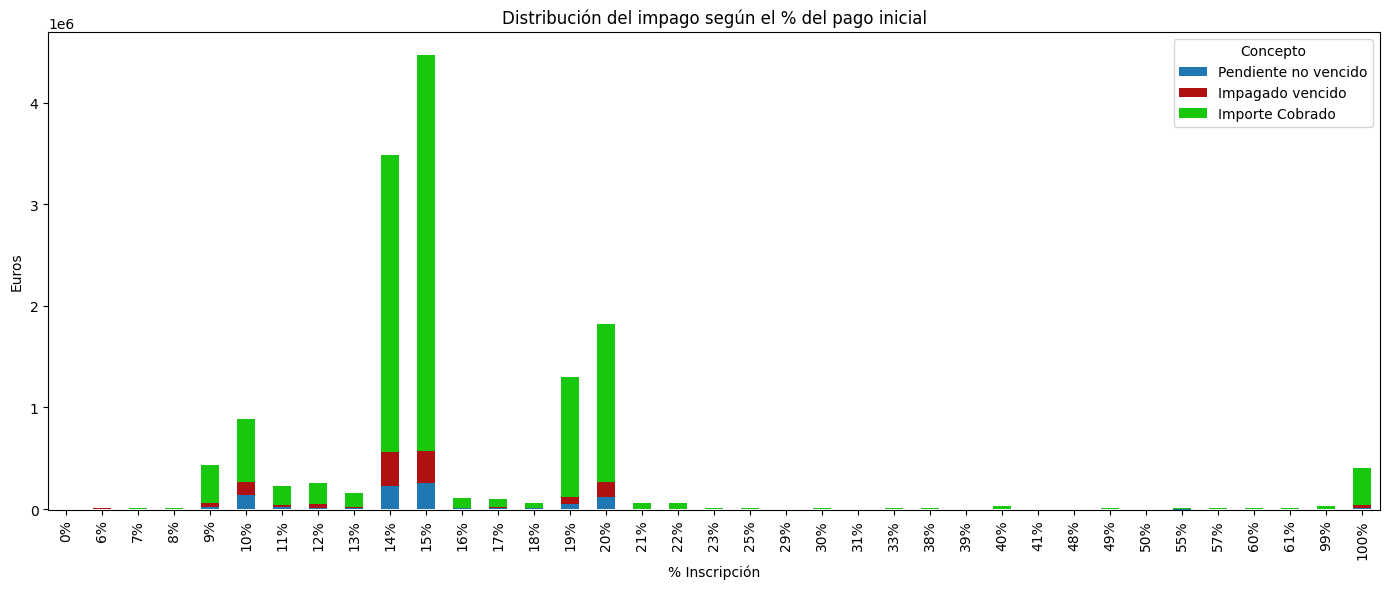

In [121]:
df_result = plot_facturacion(df_convo_deuda, os.path.join(path_reports, '01_distribucion_impago_segun_pi.jpg'))

La mayor parte de la facturación y del riesgo de impago se concentra en inscripciones con pagos iniciales bajos (10%–20%), especialmente en el 13–15%. El importe cobrado domina el gráfico, pero esos tramos también concentran los impagos y pendientes, lo que sugiere que son los segmentos críticos a analizar en profundidad (posible riesgo de clientes con baja entrada inicial).

C:\Users\joang\AppData\Local\Temp\ipykernel_5400\3013489542.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_graff.groupby('TRAMO % INSCRIPCION')[


✅ Gráfico guardado en ..\reports\02_distribucion_impago_segun_pi_100.jpg


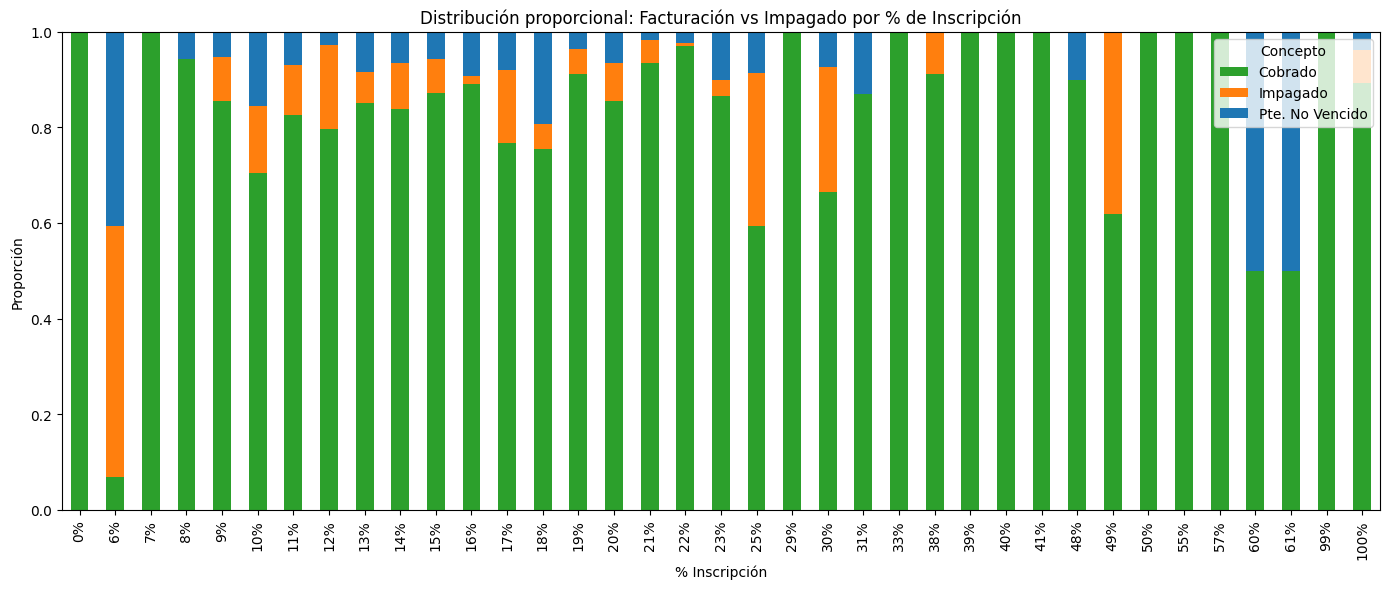

In [122]:
df_result_prop = plot_facturacion_prop(df_convo_deuda, output_path=os.path.join(path_reports, "02_distribucion_impago_segun_pi_100.jpg"))


Normalizando las diferencias de volume, se pone en evidencia que los problemas de impago están focalizados en los tramos de inscripción baja, mientras que los tramos altos muestran casi total seguridad de cobro.

C:\Users\joang\AppData\Local\Temp\ipykernel_5400\3013489542.py:214: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[


✅ Gráfico guardado en ..\reports\03_distribucion_impago_segun_pi_agrupado.jpg


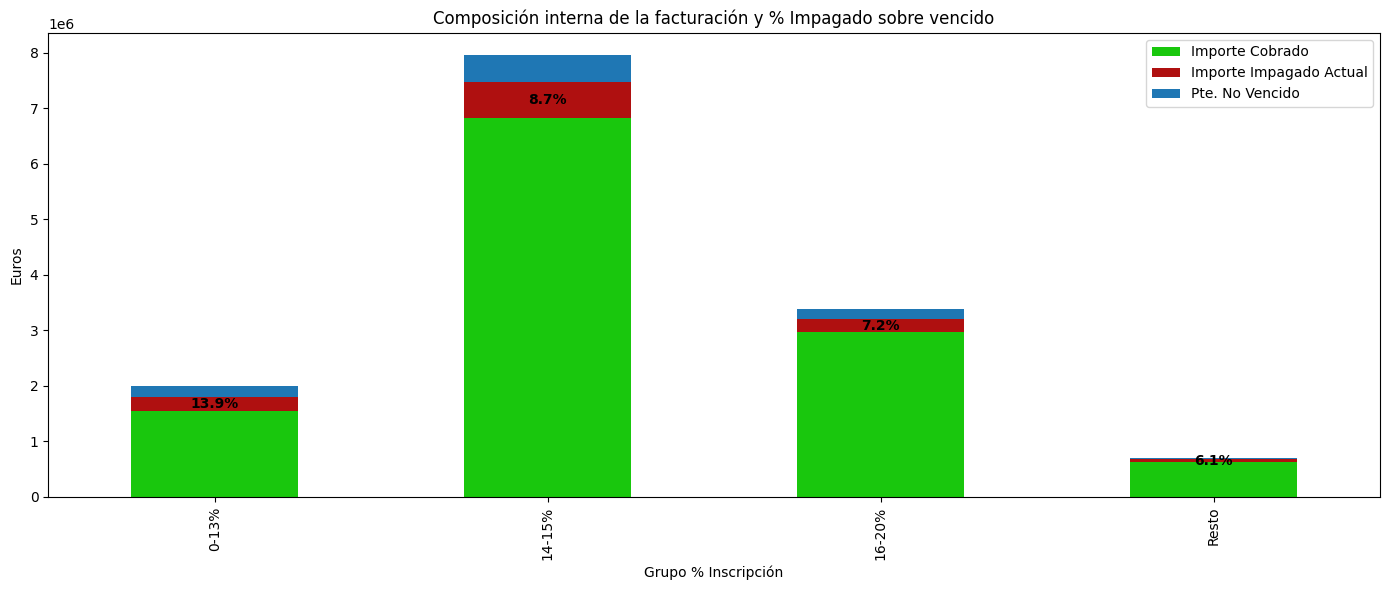

In [ ]:
df_result_agg = plot_facturacion_custom(df_convo_deuda,agrupar_tramo, 
                                        output_path=os.path.join(path_reports, "03_distribucion_impago_segun_pi_agrupado.jpg"))

C:\Users\joang\AppData\Local\Temp\ipykernel_5400\3013489542.py:214: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[


✅ Gráfico guardado en ..\reports\04_distribucion_impago_segun_pi_agrupado_2.jpg


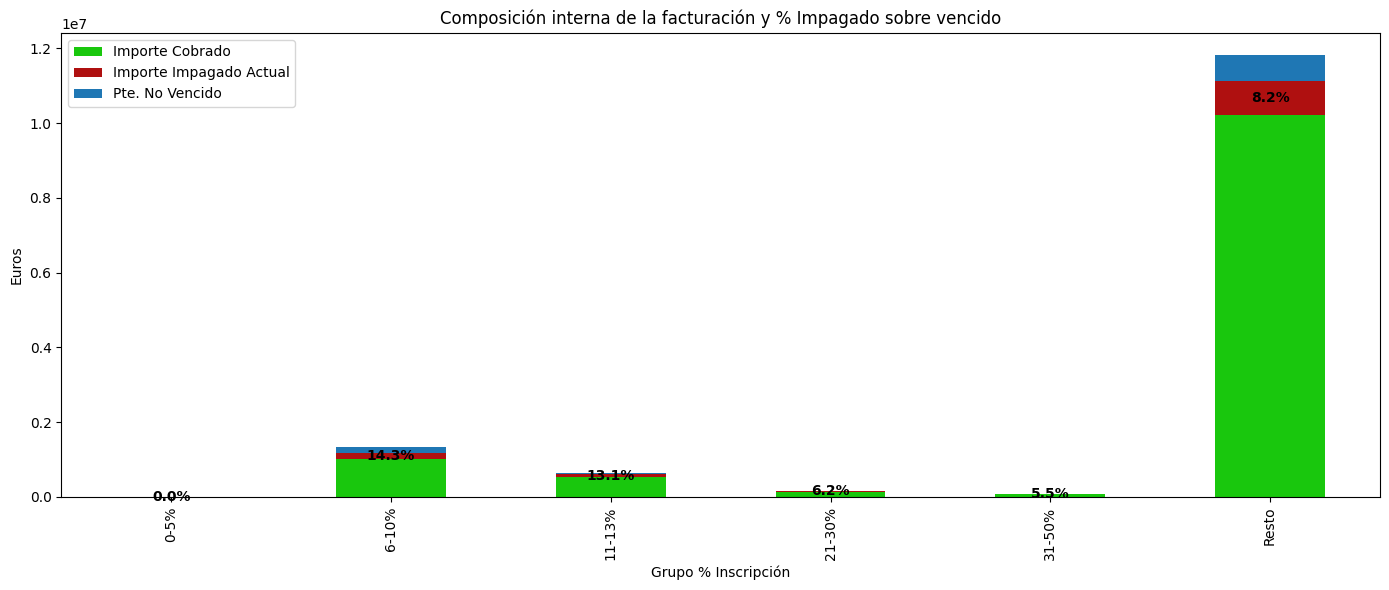

In [125]:
df_result_agg_2 = plot_facturacion_custom(df_convo_deuda,agrupar_tramo_2, 
                                          output_path=os.path.join(path_reports, "04_distribucion_impago_segun_pi_agrupado_2.jpg"),
                                          orden=['0-5%', '6-10%', '11-13%', '21-30%', '31-50%', 'Resto']
                                          )